<a href="https://colab.research.google.com/github/Renatolopo/Redes-Neurais/blob/main/RNA_Trabalho_FInal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Grupo: 
Renato Lopo Montalvão Júnior 

Mayk Brendon de Almeida Antunes

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import sys

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from keras import models, layers

## Importação dos dados


In [ ]:
# carregando a base LFW do sklearn
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(color=True)

In [ ]:
lfw_people.images.shape

(13233, 62, 47, 3)

In [ ]:
# carregando os arquivos com os nomes
famele_names = open('/content/female_names.txt').readlines()
male_names = open('/content/male_names.txt').readlines()
names = [x for x in lfw_people.target_names ]

In [ ]:
# funções para identificar o sexo de acordo com o nome
def is_famale(name):
  for i in famele_names:
    if name.replace(' ', '_') in i:
      return True
  return False

def is_male(name):
  for i in male_names:
    if name.replace(' ','_') in i:
      return True 
  return False

In [ ]:
def get_id(nome):
  return lfw_people.target_names.searchsorted(nome)

def get_sexo(nome):
  return 1 if is_male(nome) else 0

In [ ]:
nomes_F = list(filter(is_famale, names))
nomes_M = list(filter(is_male, names))

### Divisão dos dados em treino e teste

In [ ]:
X = np.zeros((lfw_people.images.shape[0], 62, 47, 3))
Y = np.zeros((lfw_people.target.shape[0], 1)) # 1 = Masculino, 0 = feminino
for i in range(lfw_people.target.shape[0]):
  X[i] = lfw_people.images[i].reshape((62,47, 3))
  name = lfw_people.target_names[lfw_people.target[i]]
  Y[i] = get_sexo(lfw_people.target_names[lfw_people.target[i]])


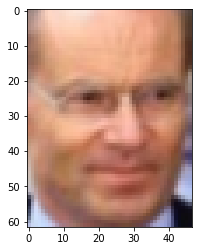

In [ ]:
plt.imshow((X[2342]).astype(np.uint8), cmap=plt.cm.gray)
plt.show()

In [ ]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, Y, test_size=0.3, random_state=0)

## Rede Convolucional

### Arquitetura do Modelo

In [ ]:
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GaussianNoise

modelo = Sequential()

modelo.add(Input((62, 47, 3)))

modelo.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
modelo.add(MaxPooling2D((2, 2)))
modelo.add(Dropout(.3))

modelo.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
modelo.add(MaxPooling2D((2, 2)))

modelo.add(Dense(100, activation='relu'))
modelo.add(Dropout(.02))

modelo.add(Flatten())

modelo.add(Dense(300, activation='relu'))
modelo.add(Dropout(.2))
modelo.add(Dense(200, activation='relu'))
modelo.add(Dropout(.2))
modelo.add(Dense(1, activation='sigmoid'))

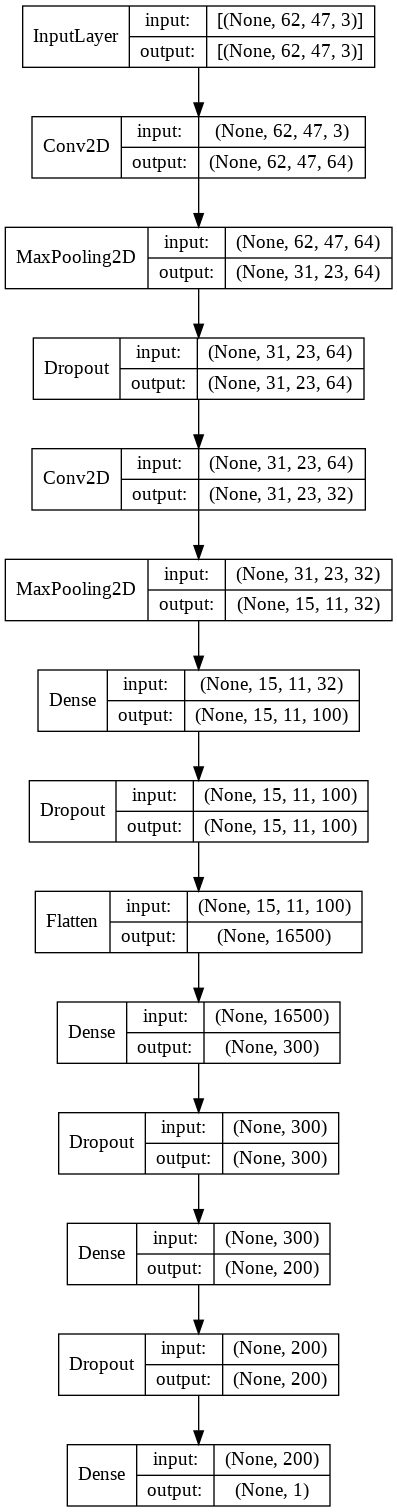

In [ ]:
from keras.utils import vis_utils
vis_utils.plot_model(modelo, show_shapes=True, 
                     show_layer_names=False, rankdir='TB') #TB

In [ ]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 47, 64)        4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 23, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 23, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 11, 32)        0         
_________________________________________________________________
dense (Dense)                (None, 15, 11, 100)       3300      
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 11, 100)       0

### Treinamento

In [ ]:
modelo.compile(optimizer= 'adam', 
               loss='binary_crossentropy', 
               metrics=['accuracy'])

log_treino = modelo.fit(
    X_treino, 
    y_treino, 
    validation_split=0.3, 
    epochs=40, 
    batch_size=200)

Epoch 1/40
33/33 [==============================] - 50s 1s/step - loss: 0.5033 - accuracy: 0.7758 - val_loss: 0.4785 - val_accuracy: 0.7992
Epoch 2/40
33/33 [==============================] - 49s 1s/step - loss: 0.4738 - accuracy: 0.7919 - val_loss: 0.4413 - val_accuracy: 0.8053
Epoch 3/40
33/33 [==============================] - 49s 1s/step - loss: 0.4660 - accuracy: 0.8009 - val_loss: 0.4843 - val_accuracy: 0.7855
Epoch 4/40
33/33 [==============================] - 49s 1s/step - loss: 0.4472 - accuracy: 0.8060 - val_loss: 0.3953 - val_accuracy: 0.8435
Epoch 5/40
33/33 [==============================] - 49s 1s/step - loss: 0.3794 - accuracy: 0.8441 - val_loss: 0.3463 - val_accuracy: 0.8532
Epoch 6/40
33/33 [==============================] - 49s 1s/step - loss: 0.3434 - accuracy: 0.8578 - val_loss: 0.2992 - val_accuracy: 0.8712
Epoch 7/40
33/33 [==============================] - 49s 1s/step - loss: 0.2995 - accuracy: 0.8820 - val_loss: 0.2907 - val_accuracy: 0.8723
Epoch 8/40
33/33 [==

Text(0.5, 1.0, 'Acurácia')

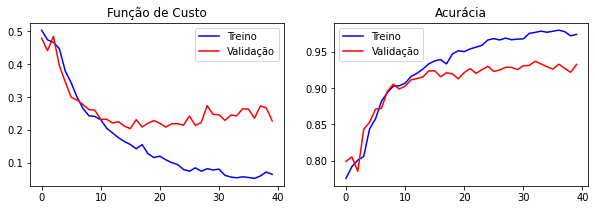

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
ax[0].plot(log_treino.history['loss'], c='blue', label='Treino')
ax[0].plot(log_treino.history['val_loss'], c='red', label='Validação')
ax[0].legend()
ax[0].set_title("Função de Custo")
ax[1].plot(log_treino.history['accuracy'], c='blue', label='Treino')
ax[1].plot(log_treino.history['val_accuracy'], c='red', label='Validação')
ax[1].legend()
ax[1].set_title("Acurácia")